2D Example demonstrating a spill and well separated by a stream.

In [41]:
import sys
import math
from io import StringIO
import os
import shutil
import platform
import numpy as np
from subprocess import check_output
import flopy
import pandas as pd
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

import config

print(np.__version__)

modelpth = os.path.join('Cara_model')
modelname = 'Spill'
mfexe = 'mfnwt'
mtexe = 'mt3dusgs'
if platform.system() == 'Windows':
    mfexe += '.exe'
    mtexe += '.exe'

# Instantiate MODFLOW model
mf = flopy.modflow.Modflow(modelname, version='mfnwt', exe_name=mfexe, 
                           model_ws=modelpth)

# Output Control: Create a flopy output control object
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0,0):['save head','save budget']})

# Newton-Rhapson Solver: Create a flopy nwt package object
headtol = 0.0001
fluxtol = 0.06
maxiterout = 200
thickfact = 1E-005
linmeth = 2
iprnwt = 1
ibotav = 0
nwt = flopy.modflow.ModflowNwt(mf, headtol=headtol, fluxtol=fluxtol, maxiterout=maxiterout,
                               thickfact=thickfact, linmeth=linmeth, iprnwt=iprnwt, ibotav=ibotav,
                               options='MODERATE')



1.14.1


Since this is a hyporthetical model, we will generate ground surface from some some equations

In [42]:
# Note that defining the ground surface this way allows to rediscretize on the fly if needed.
def topElev_Center(x,y):
    return ((-0.003 * x) + 260.) + (((-2E-9 * (x - 5000.)) + 1E-5) * (y + 1500.)**2)

# Model domain and grid definition
Lx = 10000.
Ly = 3000.
nlay = 1
nrow = 30
ncol = 100

delr = Lx / ncol
delc = Ly / nrow

xmax = ncol * delr
ymax = nrow * delc

X, Y = np.meshgrid(np.linspace(delr / 2, xmax - delr / 2, ncol),
                   np.linspace(ymax - delc / 2, 0 + delc / 2, nrow))

ibound = np.ones((nlay, nrow, ncol))

# modify the y values a bit
Y_mm = -1* np.flipud(Y)
topElev = topElev_Center(X, Y_mm)
botElev = np.zeros(topElev.shape)
strtElev= topElev - 1.

Steady = [True,False,False]
nstp = [1, 100, 200]
tsmult = [1, 1, 1]
perlen = [1, 36525, 73050]
    
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper=3, delr=delr, delc=delc,
                               top=topElev, botm=botElev, laycbd=0, itmuni=4, lenuni=1,
                               steady=Steady, nstp=nstp, tsmult=tsmult, perlen=perlen)

Now instatiate the UPW package

In [43]:
laytyp = 1
layavg = 0
chani = 1.0
layvka = 0
hdry = -2e+20
iphdry = 1
hk = 10.
hani = 1
vka = 0.01
ss = 0.00001
sy = 0.20

upw = flopy.modflow.ModflowUpw(mf, laytyp=laytyp, layavg=layavg, chani=chani, layvka=layvka,
                               ipakcb=53, hdry=hdry, iphdry=iphdry, hk=hk, hani=hani,
                               vka=vka, ss=ss, sy=sy)

# Instantiate BAS
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, hnoflo=hdry, strt=strtElev)

Now work on instantiating the boundary conditions

In [44]:
# Recharge Package: The total volume coming in from the upper and lower rows should 
# total 2000.0 on each side (4,000 total)
rech = np.zeros_like(topElev)
individual_cell_rate = 2000. / ncol / (delr*delc)
rech[0,:] = rech[-1,:] = individual_cell_rate
irch = np.zeros_like(rech)  # Remember, 0-based silliness in use
   
rch = flopy.modflow.ModflowRch(mf, nrchop=1, ipakcb=53, rech=rech, irch=irch)

In [45]:
# Evapotranspiration Package: The ET rate is 0.003 everywhere in the model, so rediscretization
# doesn't matter, can keep a constant rate.
nevtop = 1
evtr = 0.003
surf = topElev
exdp = 15
evt = flopy.modflow.ModflowEvt(mf, nevtop=nevtop, ipakcb=53, surf=surf, evtr=evtr, exdp=exdp)

In [46]:
# Streamflow Routing Package: Try and set up with minimal options in use
# 9 11 IFACE # Data Set 1: ISTCB1  ISTCB2
nstrm = 100
nss = 1
const = 1.283833650957E+005
dleak = 0.0001
istcb1 = 53
istcb2 = 0
isfropt = 0
nstrail = 10
isuzn = 1
nsfrsets = 30
irtflg = 1
numtim = 2
weight = 0.75
flwtol = 0.0001
segment_data = None
channel_geometry_data = None
channel_flow_data = None
dataset_5 = None
reachinput = False

# The next couple of lines set up the reach_data for the 30x100 hypothetical model.
# Will need to adjust the row based on which grid discretization we're doing.
# Ensure that the stream goes down one of the middle rows of the model.

# Determine the middle row and store in rMid (account for 0-base)
rMid = nrow//2 - 1

s1 = "k,i,j,iseg,ireach,rchlen,iface\n"
for y in range(ncol):
    #    layer +    row    +        col   +  iseg +   irch      +     rchlen     +    iface
    s1 += '0,' + str(rMid) + ',' + str(y) + ',1,' + str(y+1) + ',' + str(delr) + ',' + '0\n'

s1 = StringIO(s1)
reach_data = np.genfromtxt(s1, delimiter=',',names=True, dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8')])

# Will need to adjust the elevations of the upper and lower ends of the segment based on topElev array
# 5 m below ground surface (5 m of stream incision)
s2 = StringIO(u"nseg,icalc,outseg,iupseg,nstrpts,flow,runoff,etsw,pptsw,roughch,roughbk,cdpth,fdpth,awdth,bwdth,hcond1,thickm1,elevup,width1,depth1,hcond2,thickm2,elevdn,width2,depth2\n1,1,0,0,0,40000.0,0.0,0.0,0.0,0.028,0.0,0.0,0.0,0.0,0.0,1.0,1.0,254.899750,20.0,0.0,1.0,1.0,225.150250,20.0,0.0")
segment_data = np.genfromtxt(s2, delimiter=',',names=True)

# Adjust the elevations of the upstream and downstream ends of the segment
segment_data['elevup'] = topElev[rMid,0] - 5.
segment_data['elevdn'] = topElev[rMid,ncol-1] - 5.

# Be sure to convert segment_data to a dictionary keyed on stress period.
segment_data = np.atleast_1d(segment_data)
segment_data = {0: segment_data,
                1: segment_data,
                2: segment_data}

# There are 2 stress periods
dataset_5 = {0: [nss, 0, 0],
             1: [nss, 0, 0],
             2: [nss, 0, 0]}

channel_flow_data = {0: {1:[[ 1.0E+01, 1.0E+00, 2.5489975E+02, 2.0E+01],    #Data set 6b: HCOND1 THICKM1 ELEVUP WIDTH1
                            [ 1.0E+01, 1.0E+00, 2.2515025E+02, 2.0E+01]]},  #Data set 6c: HCOND2 THICKM2 ELEVDN WIDTH2
                     1: {2:[[ 1.0E+01, 1.0E+00, 2.5489975E+02, 2.0E+01],    #Data set 6b: HCOND1 THICKM1 ELEVUP WIDTH1
                            [ 1.0E+01, 1.0E+00, 2.2515025E+02, 2.0E+01]]},} #Data set 6c: HCOND2 THICKM2 ELEVDN WIDTH2

sfr = flopy.modflow.ModflowSfr2(mf, nstrm=nstrm, nss=nss, const=const, dleak=dleak,
                                ipakcb=53, istcb2=0, reach_data=reach_data, dataset_5=dataset_5,
                                segment_data=segment_data, channel_flow_data=channel_flow_data)

In [47]:
gages = [[1,int(ncol/4),61,1],[1,int(ncol/2),62,1], [1,int(ncol*3/4),63,1], [1,ncol,64,1]]
files = ['CrnkNic.gage','CrnkNic.gag1','CrnkNic.gag2','CrnkNic.gag3','CrnkNic.gag4']
gage = flopy.modflow.ModflowGage(mf, numgage=len(gages), gage_data=gages, filenames = files)

In [48]:
# Add a municipal pumping supply well
wel = flopy.modflow.ModflowWel(mf, ipakcb=53, stress_period_data = {1:[[0, 11, 74, -1.5e5],
                                                                       [0, 17, 25, 1.5e-5]]})

In [49]:
# Add the Link MT3D package for generating the linker file
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='Spill.ftl', output_file_header='extended',
                               output_file_format='formatted', package_flows = ['sfr'])

In [50]:
# Investigate the effects of hfb
mxfb = nrow
nhfbnp = nrow
hfb_data = [[0, i, 34, i, 35, 0.0001] for i in range(nrow)]   # Layer IROW1 ICOL1 IROW2  ICOL2 Hydchr 

hfb = flopy.modflow.ModflowHfb(mf, nhfbnp = nhfbnp, hfb_data = hfb_data)

In [51]:
mf.write_input()
mf.run_model()

FloPy is using the following  executable to run the model: c:\bin\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: Spill.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/24 18:37:24

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Str

 Solving:  Stress period:     2    Time step:    99    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   100    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Groundwater-Flow Eqn.

 Solving:  Stress period:     3    Time step:   107    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   108    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   109    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   110    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   111    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   112    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   113    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   114    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   115    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   116    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   117    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   118    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   119    Groundwater-Flow Eqn.

(True, [])

In [52]:
hdsobj = bf.HeadFile(os.path.join(modelpth,'{0}.hds'.format('Spill')))
totim = hdsobj.get_times()
totim
hds = hdsobj.get_data(totim=totim[0])
#hds = []
#for tm in totim:
#    hds.append(hdsobj.get_data(totim=tm))

print(hds.shape)

depth = topElev - hds[0,:,:]
print(depth.shape)
print(depth.max())
print(depth.min())


(1, 30, 100)
(30, 100)
50.367667480468754
2.364629150390641


In [53]:
hdr = ['Time', 'Stage', 'Flow', 'Depth', 'Width', 'Midpt_Flow', 'Precip', 'ET', 'Runoff']
for j in range(4):
    fname = os.path.join(modelpth, 'CrnkNic.gag' + str(j + 1))
    wha = pd.read_table(fname, header=None, skiprows=2, names=hdr, delim_whitespace=True)

    if j == 0:
        wha.drop(wha.columns.difference(['Time', 'Flow']), 1, inplace=True)
        df = wha.copy()
        df.rename(columns={'Flow': 'Flow' + str(j + 1)}, inplace=True)

    if j != 0:
        df = pd.merge(df, wha[['Time', 'Flow']], on='Time', how='left')
        df.rename(columns={'Flow': 'Flow' + str(j + 1)}, inplace=True)


df = df[['Time','Flow1','Flow2','Flow3','Flow4']]


#try:
#    plt.close('all')
#except:
#    pass

#fig = plt.figure(figsize=(15, 5), facecolor='w')
#ax = fig.add_subplot(1, 1, 1)

#lns1 = ax.plot(df['Time'], df['Flow1']*35.315/86400, 'b-', linewidth=1.0, label='1/4')
#lns2 = ax.plot(df['Time'], df['Flow2']*35.315/86400, 'k-', linewidth=1.0, label='1/2')
#lns3 = ax.plot(df['Time'], df['Flow2']*35.315/86400, 'r-', linewidth=1.0, label='3/4')
#lns4 = ax.plot(df['Time'], df['Flow2']*35.315/86400, 'g-', linewidth=1.0, label='end')

#customize plot
#ax.set_xlabel('Time, days')
#ax.set_ylabel('Flow, cfs')
#ax.set_ylim([0,20])
#ticksize = 10

# add 4 items to legend
#lns = lns1+lns2+lns3+lns4
#labs = [l.get_label() for l in lns]

#legend
#leg = ax.legend(lns,labs,
#                loc='upper left', labelspacing=0.25, columnspacing=1,
#                handletextpad=0.5, handlelength=2.0, numpoints=1)
#leg._drawFrame = False 

#plt.show()




## Setup Transport Model

In [54]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, model_ws=modelpth,
                       version='mt3d-usgs', namefile_ext='mtnam', exe_name=mtexe,
                       ftlfilename='Spill.ftl', ftlfree=True)

# BTN package
ncomp   =    1
lunit   =    'm'
sconc   =    0.0
prsity  =    sy
cinact  =   -1.0
thkmin  =    0.000001
nprs    =   -1
nprobs  =   10
nprmas  =   10
dt0     =  100.0
nstp    = nstp    # From DIS setup
mxstrn  = 5000
ttsmult =    1.0
ttsmax  =    0

#obs = [[0, 10, 15]]

btn = flopy.mt3d.Mt3dBtn(mt, MFStyleArr=True, DRYCell=True, lunit=lunit,
                         sconc=sconc, ncomp=ncomp, prsity=prsity, cinact=cinact,
                         thkmin=thkmin, nprs=nprs, nprobs=nprobs, 
                         chkmas=True,nprmas=nprmas, dt0=dt0,  
                         mxstrn=mxstrn, ttsmult=ttsmult, ttsmax=ttsmax)
# ADV package
mixelm =    0
percel =    1.0000
mxpart = 5000
nadvfd =    1      # (1 = Upstream weighting)

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=percel, mxpart=mxpart, 
                         nadvfd=nadvfd)

#GCG solver package
mxiter =   1
iter1  = 200
isolve =   3
ncrs   =   0
accl   =   1.000000
cclose =   1.00e-06
iprgcg =   5

gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=mxiter, iter1=iter1, 
                         isolve=isolve, ncrs=ncrs, accl=accl, 
                         cclose=cclose, iprgcg=iprgcg)

# SSM
# ---

# First, get a dictionary that has the SSM itype for each of the boundary types.
itype = flopy.mt3d.Mt3dSsm.itype_dict()


mxss = 3002          # maximum number of boundary conditions
ssm_data = {}
#             kss,iss,jss,css,        ITYPE
ssm_data[0] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25,   0., itype['CC'])]          #Concstant Concentration
ssm_data[1] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25, 100., itype['CC'])]
ssm_data[2] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25,   0., itype['CC'])]

ssm = flopy.mt3d.Mt3dSsm(mt, mxss=mxss, stress_period_data=ssm_data)

# SFT
# ---
dispsf = 1
coldsf = 0
seg_len = np.unique(reach_data['iseg'], return_counts=True)
obs_sf = np.cumsum(seg_len[1])
obs_sf = obs_sf.tolist()

print(seg_len)
print('value: ' + str(obs_sf))

# In the first and last stress periods, concentration at the headwater is 0.0
sf_stress_period_data = {0: [0, 0, 0.0],
                         1: [0, 0, 0.0],
                         2: [0, 0, 0.0]}

gage_output = [None, None, 'CrnkNic.sftobs']

sft = flopy.mt3d.Mt3dSft(mt, nsfinit=100, mxsfbc=100, icbcsf=81, ioutobs=82,
                         isfsolv=1, cclosesf=1.0E-5, wimp=1.0, wups=0.8, mxitersf=200, crntsf=1.0, iprtxmd=0,
                         coldsf=coldsf, dispsf=dispsf, nobssf=1, obs_sf=obs_sf,
                         sf_stress_period_data = sf_stress_period_data,
                         filenames=gage_output)



found 'rch' in modflow model, resetting crch to 0.0
found 'ets'/'evt' in modflow model, resetting cevt to 0.0
(array([1.]), array([100], dtype=int64))
value: [100]


### Run MT3D-USGS

In [55]:
mt.write_input()
mt.run_model()

FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: Spill.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.    2

 TIME STEP NO.    1
 FROM TIME =   1.0000     TO    366.25    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   101.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8797E-01  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3318E-03  [K,I,J]    1   17   28
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1452E-05  [K,I,J]    1   16   29
 Outer Iter.  1  Inner Iter.  4:  Max

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   2923.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7099E-02  [K,I,J]    1   17   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8546E-05  [K,I,J]    1   15   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7870E-07  [K,I,J]    1   14   50

 TIME STEP NO.    9
 FROM TIME =   2923.0     TO    3288.2    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   3023.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1058E-01  [K,I,J]    1   18   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2706E-04  [K,I,J]    1   18   29
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1861E-06  [K,I,J]    1   13   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   3123.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1022E-01  [K,I,J]    1   17   30
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2619E-04  [K,I,J]    1   15   32
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2301E-06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   5214.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7010E-02  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2008E-04  [K,I,J]    1   15   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9045E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   5314.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6783E-02  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1984E-04  [K,I,J]    1   15   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9687E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   5414.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6553E-02  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1960E-04  [K,I,J]    1   15   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1002E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8754E-07  [K,I,J]    1   15   36
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   9432.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3347E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1726E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1613E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8754E-07  [K,I,J]    1   15   36
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   9497.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2157E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8849E-05  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5048E-06  [K,I,J]    1   15   36

 TIME STEP NO.   27
 FROM TIME =   9497.5     TO    9862.8    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   9597.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3285E-02

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   11689.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1316E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5725E-05  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2244E-06  [K,I,J]    1   13   75

 TIME STEP NO.   33
 FROM TIME =   11689.     TO    12054.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   11789.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1977E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8659E-05  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4508E-06  [K,I,J]    1   15   36
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   11889.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1916E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1015E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5644E-06

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7078E-07  [K,I,J]    1   13   74
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   15542.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6408E-03  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1233E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2374E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7264E-07  [K,I,J]    1   13   74
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   15642.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6195E-03  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1252E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2299E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7451E-07  [K,I,J]    1   13   74
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   15707.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   19359.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1921E-03  [K,I,J]    1   17   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9384E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4387E-06  [K,I,J]    1   12   75

 TIME STEP NO.   54
 FROM TIME =   19359.     TO    19724.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   19459.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2940E-03  [K,I,J]    1   17   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1761E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1145E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2682E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   19559.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2888E-03  [K,I,J]    1   17   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1743E-04


 TIME STEP NO.   60
 FROM TIME =   21551.     TO    21916.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   21651.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2041E-03  [K,I,J]    1   16   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1449E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1070E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1895E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4657E-08  [K,I,J]    1   12   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   21751.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2003E-03  [K,I,J]    1   16   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1424E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3865E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   21851.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1965E-03


 TIME STEP NO.   66
 FROM TIME =   23742.     TO    24108.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   23842.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1315E-03  [K,I,J]    1   15   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1024E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5104E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   23942.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1284E-03  [K,I,J]    1   15   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1003E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5048E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   24042.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1254E-03  [K,I,J]    1   15   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9822E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4992E-06

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3497E-04  [K,I,J]    1   14   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2078E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1136E-06  [K,I,J]    1   12   75

 TIME STEP NO.   78
 FROM TIME =   28125.     TO    28490.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   28225.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5264E-04  [K,I,J]    1   14   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3953E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2142E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   28325.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5167E-04  [K,I,J]    1   14   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3849E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2086E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total El

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   31712.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2856E-04  [K,I,J]    1   13   83
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1579E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8382E-07  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   31778.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1846E-04  [K,I,J]    1   13   83
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7898E-06  [K,I,J]    1   12   76

 TIME STEP NO.   88
 FROM TIME =   31778.     TO    32143.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   31878.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2783E-04  [K,I,J]    1   13   83
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1511E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8009E-07  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total El

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   36261.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1488E-04  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4501E-06  [K,I,J]    1   11   77
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   36361.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1469E-04  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4483E-06  [K,I,J]    1   11   77
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   36461.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1450E-04  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4459E-06  [K,I,J]    1   11   77
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   36526.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9385E-05  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1707E-06  [K,I,J]    1   11   77

 STRESS PERIOD NO.    3

 TIME STEP NO.

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   40544.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2071E-01  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1943E-04  [K,I,J]    1   16   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4694E-06  [K,I,J]    1   14   48

 TIME STEP NO.   12
 FROM TIME =   40544.     TO    40909.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   40644.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3153E-01  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6491E-04  [K,I,J]    1   16   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6780E-06  [K,I,J]    1   14   48
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   40744.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3137E-01  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6336E-04  [K,I,J]    1   16   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1092E-05

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3078E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1028E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4470E-07  [K,I,J]    1   14   37

 TIME STEP NO.   18
 FROM TIME =   42735.     TO    43100.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   42835.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2870E-01  [K,I,J]    1   17   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9110E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2481E-05  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3278E-06  [K,I,J]    1   14   37
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   42935.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2860E-01  [K,I,J]    1   17   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9374E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2712E-05

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   44927.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2467E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4995E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6221E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3427E-06  [K,I,J]    1   15   36

 TIME STEP NO.   24
 FROM TIME =   44927.     TO    45292.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   45027.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3803E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1352E-03  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3066E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5253E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5960E-07  [K,I,J]    1   15   35
 Transport Step:    2   Step Size:   100.0     Total El

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   47118.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3378E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1637E-03  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7220E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4768E-06  [K,I,J]    1   12   75

 TIME STEP NO.   30
 FROM TIME =   47118.     TO    47484.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   47218.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5145E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3427E-03  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2018E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6557E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   47318.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5130E-01

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1574E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3228E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3456E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9239E-06  [K,I,J]    1   12   76

 TIME STEP NO.   36
 FROM TIME =   49310.     TO    49675.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   49410.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2305E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6007E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1650E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1609E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2086E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   49510.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2210E-01

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4321E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3874E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   51436.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2410E-01  [K,I,J]    1   24   68
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8155E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1122E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4500E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4172E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   51501.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1581E-01  [K,I,J]    1   24   68
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4839E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2339E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   53528.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2608E-01  [K,I,J]    1   16   77
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1460E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7169E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1454E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5960E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   53628.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2628E-01  [K,I,J]    1   16   77
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1487E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7622E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1580E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5960E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.

 TIME STEP NO.   53
 FROM TIME =   55519.     TO    55884.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   55619.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2933E-01  [K,I,J]    1   16   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1955E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8826E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2237E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5960E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   55719.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2932E-01  [K,I,J]    1   16   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1971E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9339E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1888E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5960E-06 

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   57545.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2835E-01  [K,I,J]    1   15   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2070E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1241E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9030E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3666E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.4470E-07  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   57645.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2822E-01  [K,I,J]    1   15   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2068E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1243E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1150E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   59637.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2511E-01  [K,I,J]    1   15   81
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1796E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1091E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4441E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3576E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   59737.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2493E-01  [K,I,J]    1   15   81
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1776E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1077E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4381E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3427E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1347E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7846E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3308E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2086E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   61728.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1430E-01  [K,I,J]    1   15   83
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6798E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3725E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1423E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2980E-07  [K,I,J]    1   12   76

 TIME STEP NO.   70
 FROM TIME =   61728.     TO    62094.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   61828.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2163E-01

 FROM TIME =   63554.     TO    63920.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   63654.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1905E-01  [K,I,J]    1   14   83
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9027E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4955E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2429E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2719E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   63754.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1887E-01  [K,I,J]    1   14   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8818E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4827E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2369E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2943E-06  [K,I,J]    1   12  

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1714E-06  [K,I,J]    1   11   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   65581.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1719E-01  [K,I,J]    1   14   85
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5611E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3425E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3532E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1602E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   65681.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1711E-01  [K,I,J]    1   14   85
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5459E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3521E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3427E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1549E-01  [K,I,J]    1   14   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3845E-03  [K,I,J]    1   11   78
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4888E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3055E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3092E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   67507.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1539E-01  [K,I,J]    1   14   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3863E-03  [K,I,J]    1   11   78
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4953E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3088E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3129E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   67572.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3800E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   69398.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9200E-02  [K,I,J]    1   14   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1640E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2110E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9537E-06  [K,I,J]    1   12   75

 TIME STEP NO.   91
 FROM TIME =   69398.     TO    69764.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   69498.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1399E-01  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4130E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5707E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3688E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3837E-06

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   71590.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8530E-02  [K,I,J]    1   13   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1738E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2854E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1121E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.6706E-07  [K,I,J]    1   12   75

 TIME STEP NO.   97
 FROM TIME =   71590.     TO    71955.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   71690.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1298E-01  [K,I,J]    1   13   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4096E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5126E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3904E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4284E-06

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7893E-02  [K,I,J]    1   13   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1651E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2615E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1125E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.7991E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.8071E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.3725E-08  [K,I,J]    1   12   75

 TIME STEP NO.  102
 FROM TIME =   73416.     TO    73782.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   73516.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1200E-01  [K,I,J]    1   13   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3816E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5467E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3550E-05

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   75342.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1102E-01  [K,I,J]    1   12   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3435E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5425E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2729E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4210E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   75442.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1097E-01  [K,I,J]    1   12   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3416E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5418E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2677E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4191E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6860E-02  [K,I,J]    1   12   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1351E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2901E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9779E-06  [K,I,J]    1   12   75

 TIME STEP NO.  112
 FROM TIME =   77069.     TO    77434.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   77169.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1045E-01  [K,I,J]    1   12   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3104E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5320E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2682E-05  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3986E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   77269.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1042E-01


 TIME STEP NO.  119
 FROM TIME =   79626.     TO    79991.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   79726.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1011E-01  [K,I,J]    1   11   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2722E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5632E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2587E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3502E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   79826.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1010E-01  [K,I,J]    1   11   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2709E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5656E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2615E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3483E-06

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9361E-02  [K,I,J]    1   11   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2443E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6194E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2682E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3017E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   82182.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6105E-02  [K,I,J]    1   11   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1518E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5680E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8829E-06  [K,I,J]    1   12   75

 TIME STEP NO.  126
 FROM TIME =   82182.     TO    82548.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   82282.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9308E-02

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2246E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1509E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   85039.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8907E-02  [K,I,J]    1   10   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4310E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2501E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2230E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1509E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   85104.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5820E-02  [K,I,J]    1   10   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7503E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2282E-04  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   87496.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8433E-02  [K,I,J]    1   10   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1645E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3004E-04  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1846E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1322E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   87596.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8416E-02  [K,I,J]    1   10   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1660E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2854E-04  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1831E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1322E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   90218.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5279E-02  [K,I,J]    1   10   89
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9428E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5901E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7860E-06  [K,I,J]    1   12   75

 TIME STEP NO.  148
 FROM TIME =   90218.     TO    90583.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   90318.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8059E-02  [K,I,J]    1   10   89
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1807E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1440E-04  [K,I,J]    1   12   78
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2051E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.6575E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total El

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8196E-07  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   92044.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5388E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9295E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6055E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8252E-06  [K,I,J]    1   12   75

 TIME STEP NO.  153
 FROM TIME =   92044.     TO    92409.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   92144.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8236E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1789E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1206E-04  [K,I,J]    1   12   78
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1183E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8568E-07

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8113E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1711E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1062E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1078E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8941E-07  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   93870.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5301E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8838E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5955E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9546E-06  [K,I,J]    1   12   75

 TIME STEP NO.  158
 FROM TIME =   93870.     TO    94236.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   93970.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8099E-02

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1628E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9898E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1121E-05  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8568E-07  [K,I,J]    1   12   76
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   95996.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7910E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1624E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9878E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1129E-05  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8568E-07  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   96062.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5169E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   98088.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7662E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1555E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1024E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1989E-05  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8941E-07  [K,I,J]    1   12   76
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   98188.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7646E-02  [K,I,J]    1    9   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1552E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1036E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2109E-05  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8941E-07  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:  1.00180E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7377E-02  [K,I,J]    1    9   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1488E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6020E-05  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2023E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8941E-07  [K,I,J]    1   12   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.00280E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7365E-02  [K,I,J]    1    9   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1486E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6199E-05  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1896E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8941E-07  [K,I,J]    1   12   76
 Transport Step:    3   Step Size:   100

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3316E-06  [K,I,J]    1   12   76

 TIME STEP NO.  181
 FROM TIME =  0.10227E+06 TO   0.10264E+06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:  1.02371E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7270E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1438E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7123E-05  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1155E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.9313E-07  [K,I,J]    1   12   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.02471E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7286E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1436E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7123E-05  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1147E-05

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7033E-05  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1039E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1043E-06  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:  1.04462E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4909E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7209E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3848E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1416E-06  [K,I,J]    1   12   76

 TIME STEP NO.  187
 FROM TIME =  0.10446E+06 TO   0.10483E+06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:  1.04562E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7507E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1386E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7004E-05

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7395E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1305E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6586E-05  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1010E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1602E-06  [K,I,J]    1   12   76
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:  1.06589E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7389E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1301E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6564E-05  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1013E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1714E-06  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:  1.06654E+05
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6594E-06  [K,I,J]    1   12   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.08680E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7237E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1233E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6191E-05  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6780E-06  [K,I,J]    1   12   76
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:  1.08780E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7229E-02  [K,I,J]    1    8   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1230E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6184E-05  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6929E-06  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:  1.08846E+05
 Outer Iter.  1  Inner Iter.  1:  Max. D

(False, [])

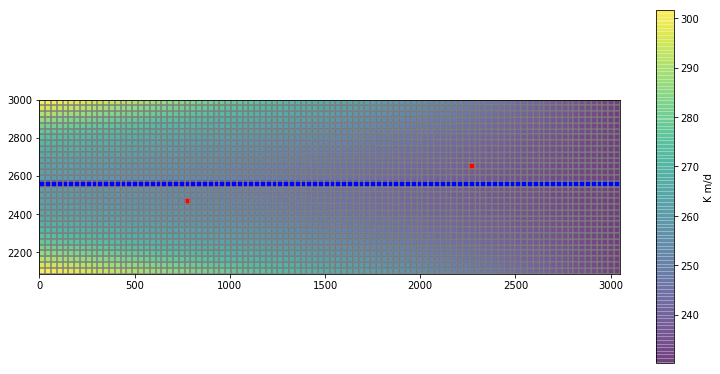

In [56]:
# plot some model attributes
fig = plt.figure(figsize=(13,13))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid()
ax = mm.ax
mf.dis.top.plot(axes=[ax],colorbar="K m/d",alpha=0.5)
mf.wel.stress_period_data.plot(axes=[ax], kper=1)
mf.sfr.stress_period_data.plot(axes=[ax])

D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\MT3DUSGS


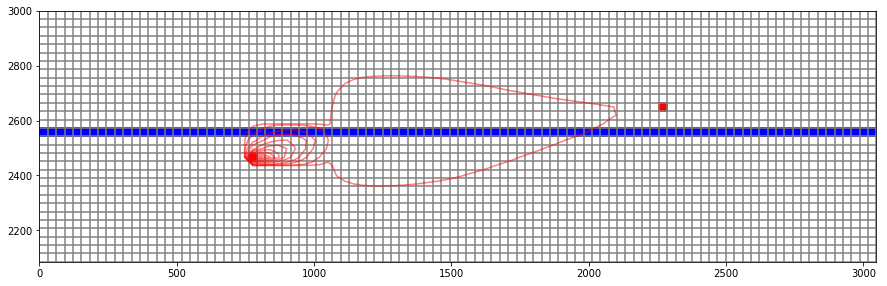

In [57]:
# Load binary concentration file
ucn = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))
totim = ucn.get_times()
conc = []
for i in totim:
    conc.append(ucn.get_data(totim=i))

conc = np.array(conc)
conc.shape

# plot the concentrations
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.set_aspect('equal')
cmin = conc.min()
cmax = conc.max()

# set the contour list
levels = np.linspace(cmin, cmax, 11)
levels = levels.tolist()
levels.pop(0)
levels = [0.1,1,5] + levels

ax.set_title('Layer {}'.format(1))
mm = flopy.plot.ModelMap(model=mf, ax=axes)
mm.plot_grid()
ax = mm.ax
mm.contour_array(conc[50,0,:,:], masked_values=[-1.], alpha=0.5, levels=levels, colors='red')

#quadmesh = mm.plot_array(conc[200,0,15:25,20:30], masked_values=[-1.], alpha=0.1, 
#                         vmin=cmin, vmax=cmax, cmap='jet')
mf.wel.stress_period_data.plot(axes=[ax], kper=1)
mf.sfr.stress_period_data.plot(axes=[ax])

print(os.getcwd())
fname = os.path.join('Cara_model', 'Spill.sftcobs.out')
# dt = pd.read_table(fname, header=[1])